In [171]:
import gspread as gs
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import time
import datetime
import matplotlib.ticker as ticker


In [172]:
# Service-account.json file is present in shared drive. To generate your own file follow steps online to create
# google-sheets api key.

In [173]:
gc = gs.service_account(filename='service-account.json')
url = "https://docs.google.com/spreadsheets/d/1I6SsB7PkomcsnYIOeSiilzNwMmZLUe1jmSSK3XWcXD4/edit?resourcekey#gid=2118111024"
sh = gc.open_by_url(url)
ws = sh.worksheet('responses')

In [174]:
df = pd.DataFrame(ws.get_all_records())
df = df[(df['Level'] != 'ButtonMovingTrapScene') & (df['Level'] != 'BlankScene')]
df.head()

,Timestamp,PlayerName,Level,PlayerDeaths,CloneDeaths,SessionID,LevelTime,Restarts,causeOfDeathPlayer,postionOfDeathPlayer,causeAndPositionOfDeathClone,collectedPill,collectedGem,ApplicationVersion,CameraHeight,CameraWidth,GUID
0,9/30/2022 12:49:07,TestUser,0-1,0,0,6.380010e+17,7.89,1,,,,,,,,,
1,9/30/2022 12:49:20,TestUser,0-2,0,2,6.380010e+17,12.66,0,,,,,,,,,
2,9/30/2022 12:49:36,TestUser,0-3,0,3,6.380010e+17,16.55,0,,,,,,,,,
3,9/30/2022 12:51:47,TestUser,0-1,0,0,6.380010e+17,3.89,0,,,,,,,,,
4,9/30/2022 12:51:52,TestUser,0-2,0,1,6.380010e+17,5.10,0,,,,,,,,,


In [175]:
pillLevels = ['5-1', '5-2', '5-3', '6-1', '6-2', '6-3']
gemLevels = ['4-1', '6-2', '7-2']
fourseries = ['4-1', '4-2', '4-3']

## Application Version Filter

In [176]:
appv = input("Enter Application Version: ")
appv = float(appv)
df = df[(df['ApplicationVersion'] == appv)]


Enter Application Version: 1.2


## Date time Filter

In [177]:
beginDate = input("Enter beginning date (mm/dd/yyyy)")
endDate = input("Enter ending date (mm/dd/yyyy)")

Enter beginning date (mm/dd/yyyy)10/20/2022
Enter ending date (mm/dd/yyyy)10/20/2022


In [178]:
beginDate = beginDate + ' 00:00:00'
endDate = endDate + ' 23:59:59'

print(beginDate)
print(endDate)

10/20/2022 00:00:00
10/20/2022 23:59:59


In [179]:
dateFormatting = lambda x : datetime.datetime.strptime(x, format_data)

In [180]:
format_data = "%m/%d/%Y %H:%M:%S"

beginDate = dateFormatting(beginDate)
endDate = dateFormatting(endDate)

df['Timestamp'] = df['Timestamp'].apply(dateFormatting)

df = df[(df['Timestamp'] >= beginDate) & (df['Timestamp'] <= endDate)]
df = df.dropna()

In [181]:
df['levelSeries'] = df['Level'].apply(lambda x: x[:1])

In [182]:
def x_coord(x):
    y = x.split(',')
    z = list(map(lambda x: float(x), y))
    xcoord = z[0]
    return xcoord

def y_coord(x):
    y = x.split(',')
    z = list(map(lambda x: float(x), y))
    ycoord = z[1]
    return ycoord

### Validation 

In [183]:
if df.isnull().values.any():
    print("Error!: Null values present")
    
invalid = df[(df['PlayerDeaths'] == 1) & (df['Restarts'] == 1)]
if len(invalid) != 0:
    print("Error!: Invalid entry present")

# Average Player and Clone Deaths per Level

<AxesSubplot: xlabel='Level'>

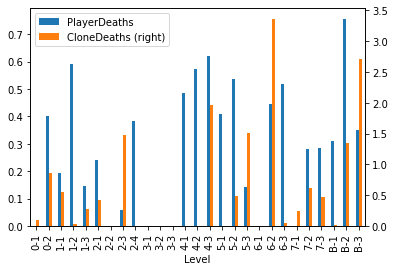

In [184]:
# Average player and clone deaths per level
deathsAvgLevel=df.groupby(by=["Level"]).aggregate({"PlayerDeaths":"mean", "CloneDeaths":"mean"})
deathsAvgLeveldf = deathsAvgLevel.reset_index()

# deathsAvgLeveldf.plot(x = 'level', y = 'playerDeaths', kind = 'barh')
deathsAvgLeveldf.plot(x = 'Level', secondary_y = 'CloneDeaths', kind = 'bar')

# Average Time taken per level

<AxesSubplot: xlabel='Level'>

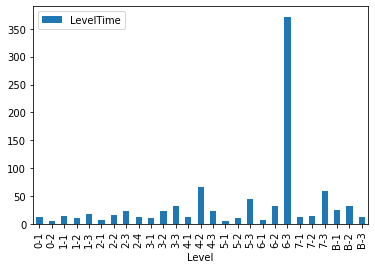

In [185]:
# Average player deaths per level
levelTimeAvgLevel=df.groupby(by=["Level"]).aggregate({"LevelTime":"mean"})
levelTimeAvgLeveldf = levelTimeAvgLevel.reset_index()

levelTimeAvgLeveldf.plot(x = 'Level', y = 'LevelTime', kind = 'bar')

# 1. Unique player attempts vs success rate per level

<AxesSubplot: xlabel='Level', ylabel='Number of Unique Players'>

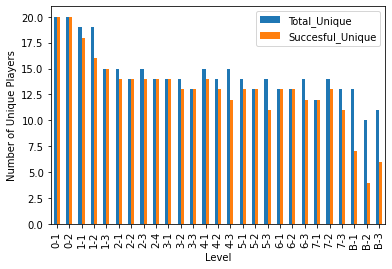

In [186]:
successAttempts = df[(df['PlayerDeaths'] == 0) & (df['Restarts'] == 0)]
failAttempts = df[(df['PlayerDeaths'] != 0) | (df['Restarts'] != 0)]
df1 = successAttempts.groupby(['Level']).aggregate({"GUID": lambda x: x.nunique()}).reset_index()
df2 = df.groupby(['Level']).aggregate({"GUID": lambda x: x.nunique()}).reset_index()
df3 = pd.merge(df1, df2, on='Level')
df3.columns = ['Level', 'Succesful_Unique', 'Total_Unique']
df3["Percentage_Succes"] = (df3['Succesful_Unique'] / df3['Total_Unique']) * 100
df3['Percentage_Succes'] = df3['Percentage_Succes'].apply(lambda x: float("{:.2f}".format(x)))
df3.plot(x = 'Level', y = ['Total_Unique', 'Succesful_Unique'], ylabel = "Number of Unique Players", kind = 'bar')


<AxesSubplot: xlabel='Level', ylabel='Percentage of Succesful Completion'>

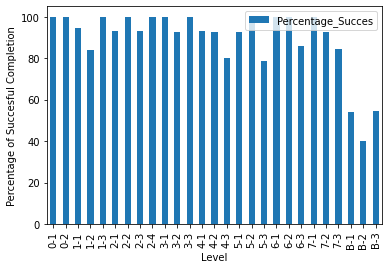

In [187]:
df3.plot(x = 'Level', y = 'Percentage_Succes', ylabel = "Percentage of Succesful Completion", kind = 'bar')

# 2. Time per attempt of every level

Text(0.5, 0, 'Levels')

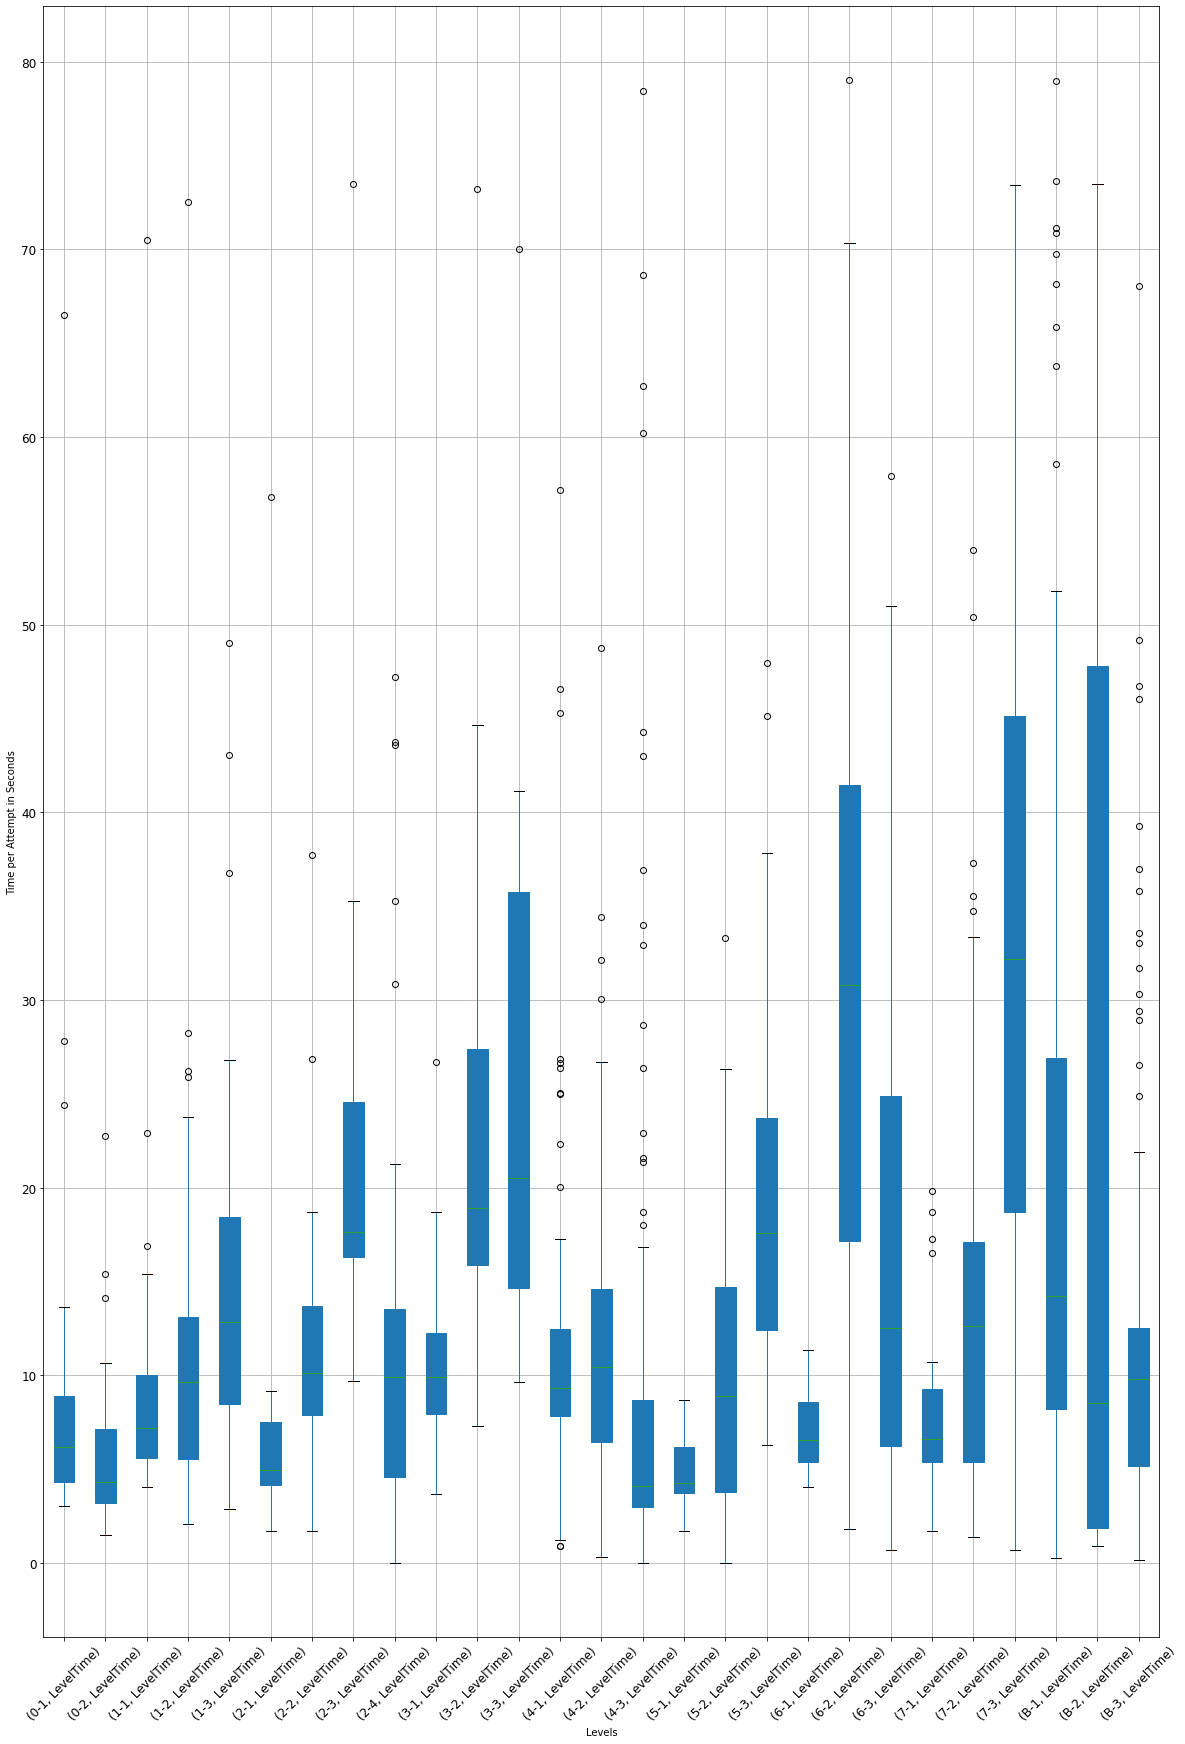

In [188]:
# clip values greater than 80
# remove top x% after review
timedf = df[df['LevelTime']<=80]
bplot = timedf.groupby("Level").boxplot(column = "LevelTime", rot=45, fontsize=12, figsize=(20,30), subplots = "False", patch_artist=True)
bplot.set_ylabel('Time per Attempt in Seconds')
bplot.set_xlabel('Levels')


# 2.2 Attempts per level

<AxesSubplot: xlabel='Levels', ylabel='Total Attempts'>

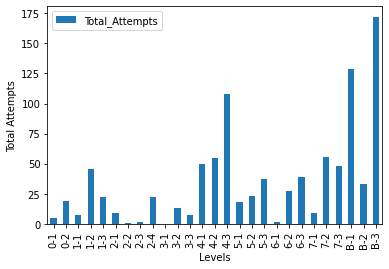

In [189]:
playerAttemptsLevel = df.groupby(["Level", "levelSeries"]).aggregate({"PlayerDeaths":"sum", "Restarts":"sum"}).reset_index()
playerAttemptsLevel
playerAttemptsLevel['Total_Attempts'] = playerAttemptsLevel['PlayerDeaths'] + playerAttemptsLevel['Restarts']
# playerAttemptsLevel = playerAttemptsLevel.unstack()
# table = pd.pivot_table(playerAttemptsLevel, index='Level', columns='levelSeries', values='Total_Attempts')
# table.plot(kind = 'bar', color=['r', 'g', 'b', 'k', 'm', 'y', 'c', 'aquamarine', 'mediumseagreen'])
playerAttemptsLevel.plot(x = 'Level', xlabel = 'Levels', y = 'Total_Attempts', ylabel = 'Total Attempts', kind = 'bar')


# 3. Average Clone Deaths vs success per Level

<AxesSubplot: xlabel='Levels', ylabel='Avg Clone Deaths'>

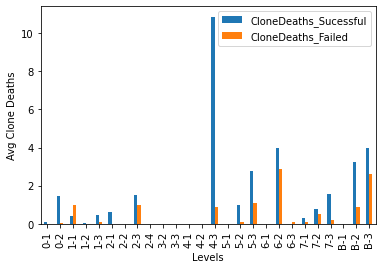

In [190]:
cloneAttemptsSuccessful=successAttempts.groupby(by=["Level"]).aggregate({"CloneDeaths":"mean"})
cloneAttemptsSuccessful = cloneAttemptsSuccessful.reset_index()
cloneAttemptsSuccessful
cloneAttemptsFailure = failAttempts.groupby(by=["Level"]).aggregate({"CloneDeaths":"mean"})
cloneAttemptsFailure = cloneAttemptsFailure.reset_index()
cloneAttemptsFailure

cloneStats = pd.merge(cloneAttemptsSuccessful, cloneAttemptsFailure, on='Level')
cloneStats.columns = ['Levels', 'CloneDeaths_Sucessful', 'CloneDeaths_Failed']
cloneStats.plot(x = 'Levels', ylabel = "Avg Clone Deaths", y = ['CloneDeaths_Sucessful', 'CloneDeaths_Failed'], kind = 'bar')


# 5. Gem Metrics

## 5.1 %age of attempts that collected gems in Levels containing them

<AxesSubplot: xlabel='Level', ylabel='% Attempts that have collected Gems'>

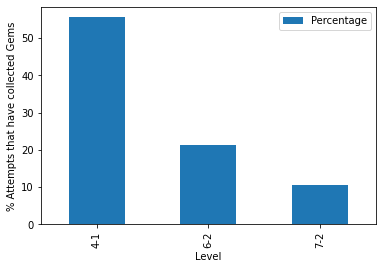

In [191]:
gemAttempts = df[(df['collectedGem'] == 'TRUE') & (df['Level'].isin(gemLevels))]
gemLevels = df[(df['Level'].isin(gemLevels))]
gemCount = gemLevels.groupby(by=['Level']).aggregate({'collectedGem':'count'}).reset_index()
gemTrue = gemAttempts.groupby(by=['Level']).aggregate({'collectedGem':'count'}).reset_index()

gemdf = pd.merge(gemTrue, gemCount, on='Level')
gemdf["Percentage"] = round((gemdf['collectedGem_x']/gemdf['collectedGem_y']) * 100, 2)
gemdf.plot(x = 'Level', ylabel = "% Attempts that have collected Gems", y = 'Percentage', kind = 'bar')



## 5.2 %age of succesful attempts that collected gems

<AxesSubplot: xlabel='Level', ylabel='% SuccesfuAttempts that have collected Gems'>

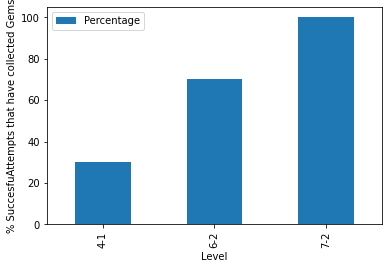

In [192]:
gemSuccessfulAttempts = gemAttempts[(gemAttempts['PlayerDeaths'] == 0) & (gemAttempts['Restarts'] == 0)]
gemSuccessCount = gemSuccessfulAttempts.groupby(by=['Level']).aggregate({'collectedGem':'count'}).reset_index()

gemdf1 = pd.merge(gemSuccessCount, gemTrue, on = 'Level')
gemdf1["Percentage"] = round((gemdf1['collectedGem_x']/gemdf1['collectedGem_y']) * 100, 2)
gemdf1.plot(x = 'Level', ylabel = "% SuccesfuAttempts that have collected Gems", y = 'Percentage', kind = 'bar')

# Pill Metrics

## 6.1 % of succesfull attempts for pill vs non-pill levels

<AxesSubplot: xlabel='Level Categories', ylabel='% Successful Attempts'>

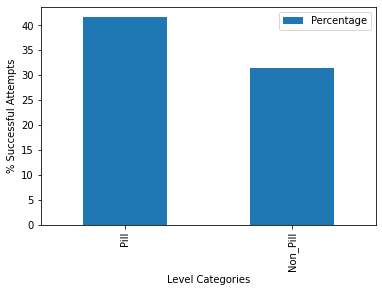

In [193]:
pillSuccessAttempts = df[(df['PlayerDeaths'] == 0) & (df['Restarts'] == 0) & (df['collectedPill'] == 'TRUE') & (df['Level'].isin(pillLevels))]
pillAttempts = df[(df['Level'].isin(pillLevels))]

pillSuccessCount = pillSuccessAttempts.groupby(by=['Level']).aggregate({'collectedPill':'count'}).reset_index()
pillAttemptsCount = pillAttempts.groupby(by=['Level']).aggregate({'collectedPill':'count'}).reset_index()

psum1 = pillSuccessCount['collectedPill'].sum()
psum2 = pillAttemptsCount['collectedPill'].sum()
pp = round((psum1/psum2) * 100, 2)
pilldf = pd.DataFrame(columns = ['x','Percentage'])
pilldf.loc[len(pilldf)] = ['Pill', pp]

successAttemptsNonPill = successAttempts[~(successAttempts['Level'].isin(pillLevels))]
totalAttemptsNonPill = df[~(df['Level'].isin(pillLevels))]
successAttemptsCount = successAttemptsNonPill.groupby(by=['Level']).size().rename('Succesful_Attempts').reset_index()
totalAttemptsCount = totalAttemptsNonPill.groupby(by=['Level']).size().rename('Total_Attempts').reset_index()

npsum1 = successAttemptsCount['Succesful_Attempts'].sum()
npsum2 = totalAttemptsCount['Total_Attempts'].sum()
npp = round((npsum1/npsum2) * 100, 2)
pilldf.loc[len(pilldf)] = ['Non_Pill', npp]

pilldf.plot(x = 'x', xlabel = "Level Categories", ylabel = "% Successful Attempts", y = 'Percentage', kind = 'bar')


## 6.2 % of succesful attempts per pill level

<AxesSubplot: xlabel='Level', ylabel='% Attempts that have collected Pills'>

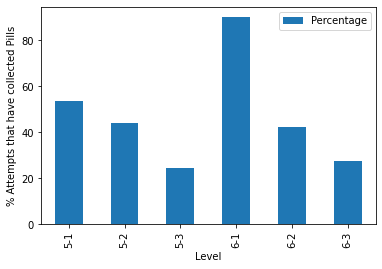

In [194]:
pillSuccessCount["Percentage"] = round((pillSuccessCount['collectedPill']/pillAttemptsCount['collectedPill']) * 100, 2)
pillSuccessCount.plot(x = 'Level', ylabel = "% Attempts that have collected Pills", y = 'Percentage', kind = 'bar')


# Metric 4: Detailed death analysis for Levels

In [231]:
causeDeath = {'Spike': 'red', 'MovingSpike': 'green', 'KillZone': 'blue'}

In [232]:
deathPos = df[['Level', 'PlayerDeaths', 'causeOfDeathPlayer', 'postionOfDeathPlayer', 'CameraHeight', 'CameraWidth']]
deathPos = deathPos.replace('', np.nan)
deathPos = deathPos.dropna()
deathPos['xcoord'] = deathPos['postionOfDeathPlayer'].apply(lambda x: x_coord(x[1:-2]))
deathPos['ycoord'] = deathPos['postionOfDeathPlayer'].apply(lambda x: y_coord(x[1:-2]))
deathPos['color'] = deathPos['causeOfDeathPlayer'].map(causeDeath)


In [233]:
camera = deathPos[['Level', 'CameraHeight', 'CameraWidth']]
cameradf = camera.groupby('Level').last().reset_index()
cameradf.loc[cameradf['Level'].isin(fourseries), 'CameraHeight'] = 15.00


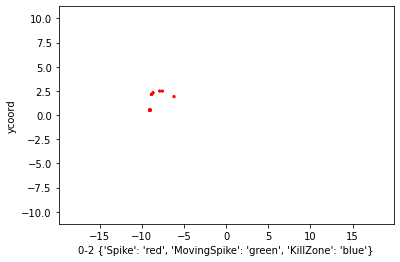

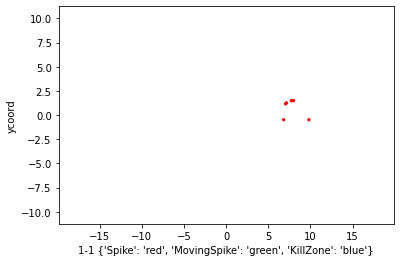

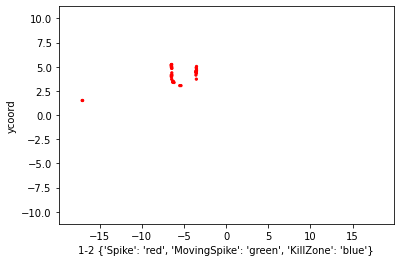

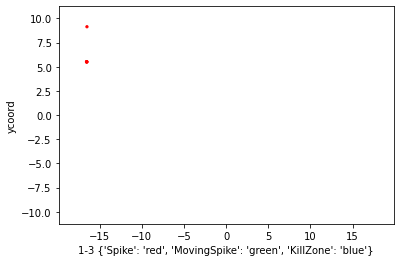

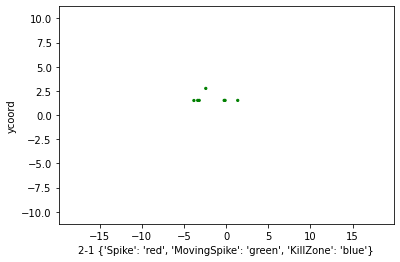

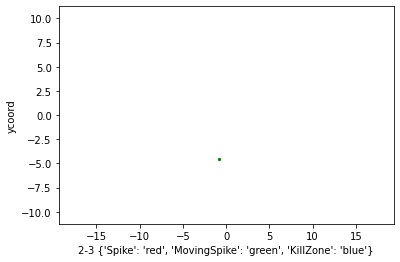

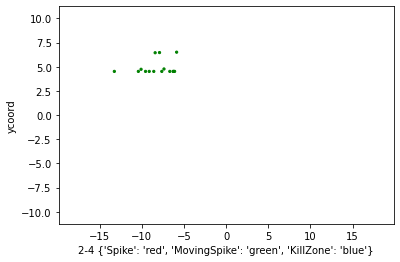

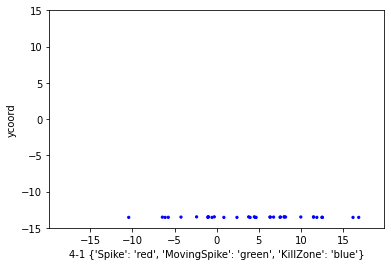

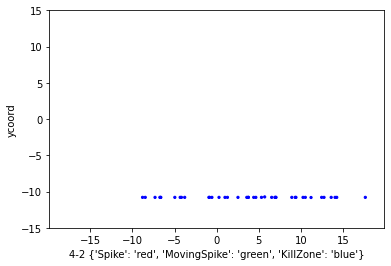

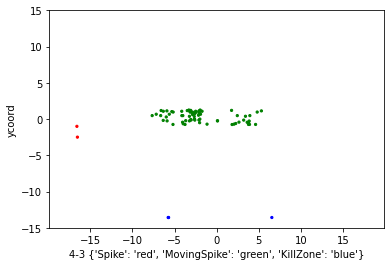

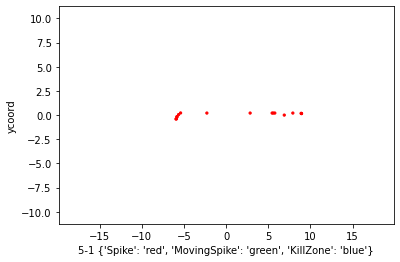

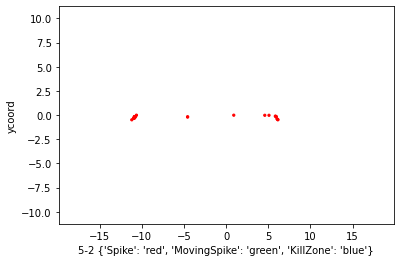

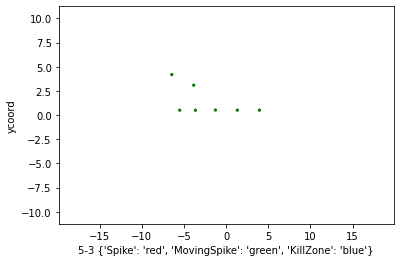

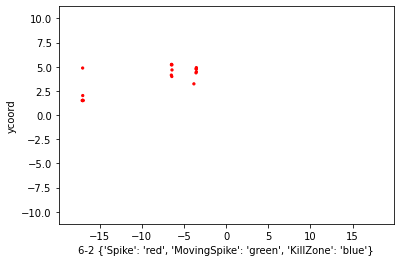

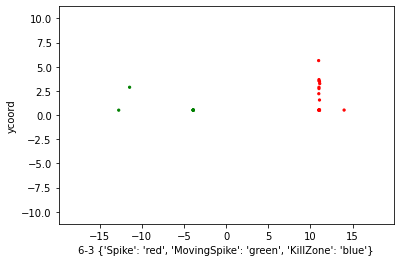

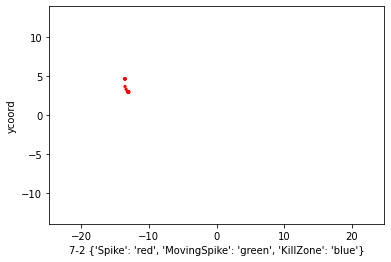

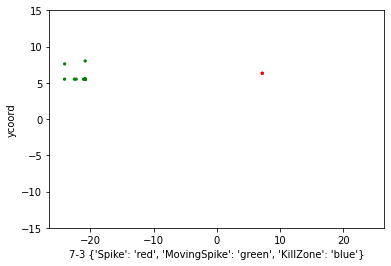

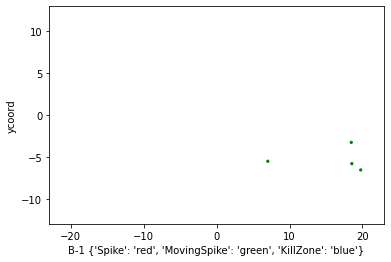

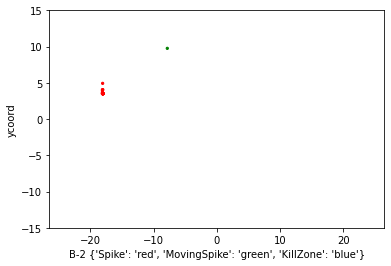

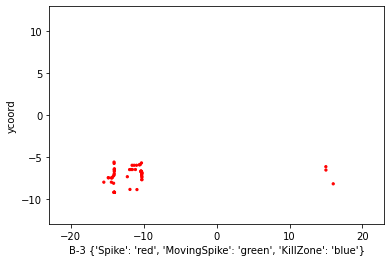

In [234]:
for index, row in cameradf.iterrows():
    deathPos[deathPos['Level'].eq(row['Level'])].plot.scatter(xlabel = row['Level'] + ' ' + str(causeDeath), 
                                                              x = 'xcoord', 
                                                              y = 'ycoord', 
                                                              s = 5, 
                                                              xlim = (-row['CameraWidth'] , row['CameraWidth']), 
                                                              ylim = (-row['CameraHeight'] , row['CameraHeight']), 
                                                              c = 'color'
                                                            
                                                             )
    
    